In [1]:
import numpy as np
import copy
import scipy.sparse as scp
from scipy.sparse import linalg

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Do not try to check it or use, while I will  not correct all steps

In [119]:
# Пока сделал так, что A уже как бы проекция. Соответственно, Omega - tuple (row, col) ее ненулевых елементов

class Problem:
    # Здесь не должно быть проблем
    def __init__(self, A, tau, rank, maxiter):
        """
        Inicialization method
        
        Args:
            A (np.array): given matrix
            tau (float): tolerance, if ||grad||<=tau - early out
            rank (int): Rank of matrix approximaИte
        """
        self.tau = tau
        self.rank = rank
        self.maxiter = maxiter
        
        self.A = A
        self.m = A.shape[0]
        self.n = A.shape[1]
        
        # (row, col) of nonzero elements in A.
        self.Omega = A.nonzero()
    
    # Эта проверена
    def projection(self, Y1, Y2):
        """
        Calculate projection of given matrix Z = Y1Y2.T.
        
        Args:
            Y1 (np.array): First matrix
            Y2 (np.array): Second matrix
        
        Returns:
            sparse csr_matrix - projection on the Omega
        """
        rows = self.Omega[0]
        cols = self.Omega[1]
        
        nnz = rows.shape[0]
        data = np.zeros(rows.shape[0])
        
        for it in range(0, nnz):
            data[it] = np.dot(Y1[rows[it]].T, Y2[cols[it]])
        
        proj = scp.csr_matrix((data, (rows, cols)), shape=self.A.shape)
        
        return proj
    
    # Здесь вроде негде налажать
    def grad(self, svd, Rw):
        """
        Compute gradient in the current point
        
        Args:
            svd (list): SVD of the current point
            Rw (np.array): Xw - Aw
        Returns:
            np.array, list: Gradient and corresponding matrices [value, [M, Up, Vp]]
        """
        U = svd[0]
        V = svd[2]
        
        Ru = Rw.T.dot(U)
        Rv = Rw.dot(V)
        
        M = np.dot(U.T, Rv)
        
        Up = Rv - np.dot(U, M)
        Vp = Ru - np.dot(V, M.T)
        
        grad_value = U.dot(M.dot(V.T)) + Up.dot(V.T) + U.dot(Vp.T)
        grad_list = [M, Up, Vp]
        grad = [grad_value, grad_list]
        
        return grad
    
    def vector_transport(self, X_old_svd, X_new_svd, v_list):
        """
        Calculate transport vector from previous tangent space to new tangent space
        
        Args:
            X_old_svd (list): SVD in the previous point in the form [U, S, V], X = USV.T
            X_new_svd (list): SVD in the new point in the form [U+, S+, V+], X+ = U+S+V+.T
            v_list (list): vector, we need to transport in the form [M, Up, Vp]

        Returns:
            np.array, list: Transport vector and corresponding matrices [value, [M+, Up+, Vp+]]
        """
        
        U = X_old_svd[0]
        S = X_old_svd[1]
        V = X_old_svd[2]
    
        U_plus = X_new_svd[0]
        S_plus = X_new_svd[1]
        V_plus = X_new_svd[2]
        
        M = v_list[0]
        Up = v_list[1]
        Vp = v_list[2]
        
        Av = np.dot(V.T, V_plus)
        Au = np.dot(U.T, U_plus)
        
        Bv = np.dot(Vp.T, V_plus)
        Bu = np.dot(Up.T, U_plus)
        
        M_plus_one = np.dot(Au.T, np.dot(M, Av))
        U_plus_one = np.dot(U, np.dot(M, Av))
        V_plus_one = np.dot(V, np.dot(M.T, Au))
        
        M_plus_two = np.dot(Bu.T, Av)
        U_plus_two = np.dot(Up, Av)
        V_plus_two = np.dot(V, Bu)
        
        M_plus_three = np.dot(Au.T, Bv)
        U_plus_three = np.dot(U, Bv)
        V_plus_three = np.dot(Vp, Au)
        
        M_plus = M_plus_one + M_plus_two + M_plus_three
        Up_plus = U_plus_one + U_plus_two + U_plus_three
        Up_plus = Up_plus - np.dot(U_plus, np.dot(U_plus.T, Up_plus))
        
        Vp_plus = V_plus_one + V_plus_two + V_plus_three
        Vp_plus = Vp_plus - np.dot(V_plus, np.dot(V_plus.T, Vp_plus))
        
        transport_value = np.dot(U_plus, np.dot(M_plus, V_plus.T)) + np.dot(Up_plus, V_plus.T) \
                                                        + np.dot(U_plus, Vp_plus.T)
        
        
        transport_list = [M_plus, Up_plus, Vp_plus]
        transport = [transport_value, transport_list]
        return transport
    
    def conjugate_direction(self, X_old_svd, X_new_svd, xi_old, xi_new, eta_old):
        """
        Compute the conjugate direction by PR+ in the new point
        
        Args:
            X_old_svd (list): SVD in the previous point in the form [U, S, V], X = USV.T
            X_new_svd (list): SVD in the new point in the form [U+, S+, V+], X+ = U+S+V+.T
            xi_old (list): tangent vector in the previous point in the form [value, [M, Up, Vp]]
            xi_new (list): tangent vector in the new point in the form [value, [M, Up, Vp]]
            eta_old (list): conjugate vector in the previous point in the form [value, [M, Up, Vp]]

        Returns:
            np.array, list: conjugate vector and corresponding list in the new point [M+, Up+, Vp+]
        """
        # Transport previous gradient and direction to current tangent space:
        xi_bar = self.vector_transport(X_old_svd, X_new_svd, xi_old[1])
        eta_bar = self.vector_transport(X_old_svd, X_new_svd, eta_old[1])
        
        # Compute conjugate direction
        delta = xi_new[0] - xi_bar[0]
        top = np.trace(np.dot(delta.T, xi_new[0]))
        
        # Пока с trace, переделать
        bottom = np.trace(np.dot(xi_old[0].T, xi_old[0]))
        betta = np.maximum(0, top/bottom)
        #print('betta', betta)
        eta_value = -xi_new[0] + betta*eta_bar[0]
        
        # Renew eta_list
        M_eta_bar = eta_bar[1][0]
        Up_eta_bar = eta_bar[1][1]
        Vp_eta_bar = eta_bar[1][2]
        
        M_xi = xi_new[1][0]
        Up_xi = xi_new[1][1]
        Vp_xi = xi_new[1][2]
        

        M_eta = -M_xi + betta*M_eta_bar
        Up_eta = -Up_xi + betta*Up_eta_bar
        Vp_eta = -Vp_xi + betta*Vp_eta_bar
        
        eta_list = [M_eta, Up_eta, Vp_eta]
        
        eta = [eta_value, eta_list]
        
        # Compute angle between conjugate direction and gradient:
        
        top = np.trace(np.dot(eta[0].T, xi_new[0]))
        bottom = np.sqrt(np.trace(np.dot(eta[0].T, eta[0]))*np.trace(np.dot(xi_new[0].T, xi_new[0])))
        alpha = top/bottom
        #print(bottom)
        
        # Reset to gradient if desired:
        if np.abs(alpha) <= 0.1:
            print('alpha: ', alpha)
            eta_value = xi_new[0].copy()
            eta_list = xi_new[1].copy()
            eta = [eta_value, eta_list]
        
        return eta
    
    def compute_initial_guess(self, X_new_svd, Rw, eta_new):
        """
        Compute the initial guess for line search t* = argmin_t f(X+t*eta)
        Args:
            X_new_svd (list): SVD in the new point in the form [U, S, V], X = USV.T
            Rw (np.array): Rw = Xw - Aw
            eta_new (list): conjugate vector in the new point in the form [value, [M, Up, Vp]]
        Returns:
            t (float)
        
        """
        R = -Rw
        U = X_new_svd[0]
        V = X_new_svd[2]
        M = eta_new[1][0]
        Up = eta_new[1][1]
        Vp = eta_new[1][2]
        
        Y1 = np.dot(U, M) + Up
        Y1 = np.hstack((Y1, U))
        Y2 = np.hstack((V, Vp))
        N = self.projection(Y1, Y2)
        top = N.T.dot(R)
        bottom = N.T.dot(N)
        t = top.diagonal().sum() / bottom.diagonal().sum()
        return t
            
    
    def compute_retraction(self, X_new_svd, xi_new_list):
        """
        Compute the retraction by metric projection
        Args:
            X_new_svd (list): SVD in the new point in the form [U, S, V], X = USV.T
            xi_new_list (list): tangent vector in the new point in the form [M, Up, Vp]
        Returns:
            retraction (list): Retraction on Mk manifold from tangent space after some step
                                    in the form [U, S, V], and  X = USV.T
        """
        k = self.rank
        M = xi_new_list[0]
        Up = xi_new_list[1]
        Vp = xi_new_list[2]

        U  = X_new_svd[0]
        Sigma = X_new_svd[1]
        V  = X_new_svd[2]
        
        Zero = np.zeros((k, k))
        (Qu, Ru) = np.linalg.qr(Up)
        (Qv, Rv) = np.linalg.qr(Vp)
        top = np.hstack((Sigma + M, Rv.T))
        bottom = np.hstack((Ru, Zero))
        S = np.vstack((top, bottom))
        Us, Sigmas, Vs = np.linalg.svd(S)
        
        #e_mach = np.random.uniform(0, 0.0001, k)
        Sigma_plus = np.diag(Sigmas[0:k] + 1e-16)
        
        Current = np.hstack((U, Qu))
        U_plus = np.dot(Current, Us)[:, :k]

        Current = np.hstack((V, Qv))
        V_plus = np.dot(Current, Vs)[:, :k]
        
        #ans = np.dot(U_plus, np.dot(Sigma_plus, V_plus.T))
        retraction = [U_plus, Sigma_plus, V_plus]
        return retraction
        
    def Initialization(self):
        """
        Compute an initialization for X_old_svd, X_new_svd, xi_old, xi_new, eta_old
        
        Returns:
            X_old_svd (list): SVD in the previous point in the form [U, S, V], X = USV.T
            X_new_svd (list): SVD in the new point in the form [U, S, V], X = USV.T
            xi_old (list): tangent vector in the previous point in the form [value, [M, Up, Vp]]
            eta_old (list): conjugate vector in the previous point in the form [value, [M, Up, Vp]]
            
        """
        m = self.m
        n = self.n
        k = self.rank
        
        diag = np.random.uniform(0, 1, k)
        diag = np.sort(diag)[::-1]
        
        S1 = np.diag(diag)
        U1 = np.random.uniform(0, 1, (m, k))
        V1 = np.random.uniform(0, 1, (n, k))
        
        Qu1, Ru1 = np.linalg.qr(U1)
        Qv1, Rv1 = np.linalg.qr(V1)
        X_new_svd = [Qu1, S1, Qv1]
    
        Xw = self.create_Xw(X_new_svd)
            
        # Calculation P_w(X-A) = Xw-Aw = Xw - A
        Rw = Xw - self.A
            
        # Compute the gradient and direction
        xi_new = self.grad(X_new_svd, Rw)
        eta_new = copy.deepcopy(xi_new)
            
        # Compute Retraction
        X_cur_svd = self.line_search(X_new_svd, Rw, xi_new, eta_new)
            
        X_old_svd = copy.deepcopy(X_new_svd)
        X_new_svd = copy.deepcopy(X_cur_svd)

        return(X_old_svd, X_new_svd, xi_new, eta_new)
        
    
    def line_search(self, X_new_svd, Rw, xi_new, eta_new):
        """
        Line search for finding m and t
        Args:
            
        Returns:
        """
        f_old = 0.5*(linalg.norm(Rw)**2)
        # Determine an initial step ti from the linearized problem
        t = self.compute_initial_guess(X_new_svd, Rw, eta_new)
        m = 0        
        while True:
            step = (0.5**m)*t
            #print('step', step)
            #print('m', m)
            M_step = eta_new[1][0]*step
            Up_step = eta_new[1][1]*step
            Vp_step = eta_new[1][2]*step
            eta_new_step = [M_step, Up_step, Vp_step]
            
            # Compute Retraction
            X_cur_svd = self.compute_retraction(X_new_svd, eta_new_step)
            Xw_new = self.create_Xw(X_cur_svd)
            Rw_new = Xw_new - self.A
            f_new = 0.5*(linalg.norm(Rw_new)**2)
            print('%', f_old - f_new)
            if (f_old - f_new >= -0.0001*step*np.trace(np.dot(eta_new[0].T, xi_new[0]))):
                break
            m = m + 1
        print('m', m)
        return X_cur_svd
    
    
    def line_search1(self, X_new_svd, Rw, xi_new, eta_new):
        """
        Line search for finding m and t
        Args:
            
        Returns:
        """
        f_old = 0.5*(linalg.norm(Rw)**2)
        # Determine an initial step ti from the linearized problem
        t = self.compute_initial_guess(X_new_svd, Rw, eta_new)
        m = 0        
        #while True:
        step = 0.1
            #print('step', step)
            #print('m', m)
        M_step = eta_new[1][0]*step
        Up_step = eta_new[1][1]*step
        Vp_step = eta_new[1][2]*step
        eta_new_step = [M_step, Up_step, Vp_step]
            
        # Compute Retraction
        X_cur_svd = self.compute_retraction(X_new_svd, eta_new_step)
        Xw_new = self.create_Xw(X_cur_svd)
        Rw_new = Xw_new - self.A
        f_new = 0.5*(linalg.norm(Rw_new)**2)
        print('%', f_old - f_new)
        #    if (f_old - f_new >= -0.0001*step*np.trace(np.dot(eta_new[0].T, xi_new[0]))):
        #        break
        #    m = m + 1
        print('m', m)
        return X_cur_svd
    
    def create_Xw(self, X_svd):
        """
        Take svd decomposition of X in the form [U, Sigma, V]
        and calculate projection Xw
        Args:
            Xw (sparse): Projection
        """
        # Projection of X
        Y1 = np.dot(X_svd[0], X_svd[1])
        Y2 = X_svd[2]
        Xw = self.projection(Y1, Y2)
        return(Xw)
    
    def LRGeomCG(self):
        
        residuals = []
        X_old_svd, X_new_svd, xi_old, eta_old = self.Initialization()
        iters=0
        while True:
            if(iters > self.maxiter):
                break
            print('Num_iteration:', iters)
            iters+=1

            
            # Calculation P_w(X-A) = Xw-Aw = Xw - A
            Xw = self.create_Xw(X_new_svd)
            Rw = Xw - self.A
            
            # Compute the gradient
            xi_new = self.grad(X_new_svd, Rw)
            
            # Check convergence
            if np.linalg.norm(xi_new[0]) <= self.tau:
                break
            
            # Compute a conjugate direction by PR+
            eta_new = self.conjugate_direction(X_old_svd, X_new_svd, xi_old, xi_new, eta_old)
            
            # Compute Retraction
            X_cur_svd = self.line_search(X_new_svd, Rw, xi_new, eta_new)
            
            # Renew X_old_svd and X_new_svd
            X_old_svd = copy.deepcopy(X_new_svd)
            X_new_svd = copy.deepcopy(X_cur_svd)
            
            # Renew xi_old and eta_new
            xi_old = copy.deepcopy(xi_new)
            eta_old = copy.deepcopy(eta_new)
            
            ################
            #Проверка, что мы всегда на многообразии
            U = X_new_svd[0]
            S = X_new_svd[1]
            V = X_new_svd[2]
            Ans = U.dot(S.dot(V.T))
            #print('rank:', np.linalg.matrix_rank(Ans))
            ################
            # Calculate residuals
            Xw = self.create_Xw(X_new_svd)
            Rw = Xw - self.A
            cur_res = 0.5*(linalg.norm(Rw)**2)
            residuals.append(cur_res)
            
        self.residuals = residuals
        self.approx = copy.deepcopy(X_new_svd)
        pass

# Debag

In [120]:
diags = np.arange(-99, 100, 10)
A = scp.diags(diagonals=np.ones(diags.size), offsets=diags, shape=(100, 100))
A

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements (20 diagonals) in DIAgonal format>

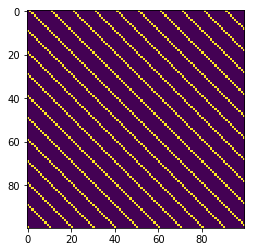

In [121]:
plt.imshow(A.toarray())
plt.show()

In [137]:
np.random.seed(123)
problem = Problem(A, tau=1e-8, rank=10, maxiter=5)

In [138]:
np.seterr(all='raise')

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [139]:
problem.LRGeomCG()

% 70.7452418116
m 0
Num_iteration: 0
% 55.6134602288
m 0
Num_iteration: 1
% -39.0609330618
% 6.10105812273
m 1
Num_iteration: 2
% -74.0452110344
% 36.9942921234
m 1
Num_iteration: 3
% -266.827052685
% 56.3073506758
m 1
Num_iteration: 4
% -251.546079567
% -146.322993617
% -64.5776044049
% -26.3693858477
% -18.0329194043
% -5.54594620075
% -1.99687850531
% -1.12260874161
% -0.554903840208
% -0.275843697286
% -0.137518820142
% -0.0686585337685
% -0.0343040330634
% -0.0171457062429
% -0.00696861511983
% -0.00348393422433
% -0.00174187377547
% -0.000870913553399
% -0.000435450942803
% -0.000217724012998
% -0.000108861641763
% -5.44307299606e-05
% -2.72153422998e-05
% -1.36076655508e-05
% -6.80383135432e-06
% -3.40191542136e-06
% -1.7009573412e-06
% -8.50478784287e-07
% -4.25232030921e-07
% -2.12616043882e-07
% -1.06305833469e-07
% -5.31503587808e-08
% -2.65726498583e-08
% -1.32841364575e-08
% -6.63987975713e-09
% -3.31789351549e-09
% -1.65687197295e-09
% -8.23547452455e-10
% -4.09386302636e

In [140]:
U = problem.approx[0]
S = problem.approx[1]
V = problem.approx[2]
Ans = U.dot(S.dot(V.T))
np.linalg.matrix_rank(Ans)

10

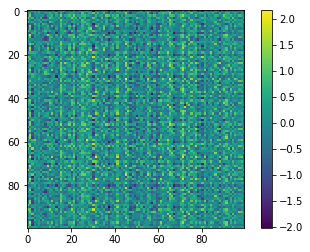

In [141]:
plt.imshow(Ans)
plt.colorbar()
plt.show()

In [142]:
Xw = problem.create_Xw(problem.approx)
Aw = problem.A
Rw = Xw - Aw

In [143]:
0.5*(linalg.norm(Rw)**2)

266.67522874336373

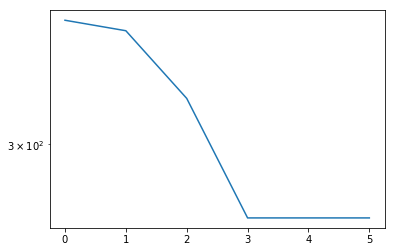

In [144]:
plt.plot(problem.residuals)
plt.yscale('log')

In [145]:
problem.residuals

[366.07792966531645,
 359.97687154258665,
 322.98257941916694,
 266.67522874336402,
 266.67522874336379,
 266.67522874336373]

# Block-diag

In [80]:
np.random.seed(123)
k = 5
m = 7
n = 4
diag = np.random.uniform(0, 1, k)
diag = np.sort(diag)[::-1]
        
S1 = np.diag(diag)
U1 = np.random.uniform(0, 1, (m, k))
V1 = np.random.uniform(0, 1, (n, k))

Y1 = np.dot(U1, S1)
Y2 = V1

In [81]:
Omega = [np.array([0, 0, 2, 3, 4]), np.array([0, 1, 1, 2, 2])]

In [82]:
def projection(Y1, Y2, Omega):

    rows = Omega[0]
    cols = Omega[1]        
        
    nnz = rows.shape[0]
    data = np.zeros(rows.shape[0])
        
    for it in range(0, nnz):
        data[it] = np.dot(Y1[rows[it]].T, Y2[cols[it]])
        
    proj = scp.csr_matrix((data, (rows, cols)), shape=(5,4))
        
    return proj

In [83]:
proj = projection(Y1, Y2, Omega)

In [84]:
proj.toarray()

array([[ 0.52285372,  0.9043002 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.44266464,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.93626166,  0.        ],
       [ 0.        ,  0.        ,  0.40700982,  0.        ]])

In [85]:
def update_Z_proj(Y1, Y2, Omega):
    U = Y1
    Vt = Y2.T
    
    proj_data = np.empty(Omega[0].size)
    for i in range(Omega[0].size):
         proj_data[i] = U[Omega[0][i], :].dot(Vt[:, Omega[1][i]])
    Z_proj = scp.csr_matrix((proj_data, Omega), (5, 4))
    return Z_proj

In [86]:
Z_proj = update_Z_proj(Y1, Y2, Omega)

In [87]:
Z_proj.toarray()

array([[ 0.52285372,  0.9043002 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.44266464,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.93626166,  0.        ],
       [ 0.        ,  0.        ,  0.40700982,  0.        ]])

In [199]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
A = scp.csr_matrix((data, (row, col)), shape=(3, 3))
A

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [200]:
Ad = A.toarray()
Ad

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]], dtype=int64)

In [201]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([-1, 2, -1, 4, 5, -6])
B = scp.csr_matrix((data, (row, col)), shape=(3, 3))
B

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [204]:
Bd = B.toarray()
Bd

array([[-1,  0,  2],
       [ 0,  0, -1],
       [ 4,  5, -6]], dtype=int64)

In [205]:
Ad.dot(Bd)

array([[  7,  10, -10],
       [ 12,  15, -18],
       [ 20,  30, -33]], dtype=int64)

In [206]:
(A.dot(B)).toarray()

array([[  7,  10, -10],
       [ 12,  15, -18],
       [ 20,  30, -33]], dtype=int64)

In [214]:
Cd = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
A.dot(Cd)

array([[15, 18, 21],
       [21, 24, 27],
       [66, 81, 96]], dtype=int64)

In [215]:
Ad.dot(Cd)

array([[15, 18, 21],
       [21, 24, 27],
       [66, 81, 96]], dtype=int64)

In [457]:
a = [np.array([1, 2, 3]), np.array([4, 5, 6])]
b = [np.array([1, 2, 3]), np.array([1, 1, 1])]
a[0] - b[1]

array([0, 1, 2])